In [ ]:
%pip install numpy pandas matplotlib seaborn scikit-learn keras keras-tuner tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

import keras_tuner as kt
import os

## Data Loading & EDA

In [ ]:
df = pd.read_csv('balanced_dataset.csv')
df.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
0,Bengaluru,48.59,103.22,3.47,27.00,18.04,28.02,3.89,1.94,52.96,21.33,196.72,91
1,Bengaluru,47.38,103.22,2.84,22.39,15.33,23.19,11.29,2.05,71.85,14.97,138.20,120
2,Bengaluru,65.65,103.22,3.10,26.35,17.45,27.76,9.95,6.30,72.84,9.88,100.77,154
3,Bengaluru,60.47,103.22,5.39,29.87,20.88,35.10,1.46,6.07,64.12,5.90,61.48,119
4,Bengaluru,62.56,103.22,3.16,23.57,16.39,27.13,10.05,4.98,82.34,4.53,39.99,232


In [ ]:
# Check for missing values
print(df.isnull().sum())
# Basic statistics
df.describe()

City       0
PM2.5      0
PM10       0
NO         0
NO2        0
NOx        0
NH3        0
CO         0
SO2        0
O3         0
Benzene    0
Toluene    0
AQI        0
dtype: int64


,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,AQI
count,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000,13993.000000
mean,59.908393,122.075805,17.141790,33.596466,35.625192,27.571431,1.116699,9.984700,38.073336,3.709960,9.310697,138.762095
std,51.710484,81.419499,22.851014,21.035980,33.730667,26.892597,1.833690,6.713632,21.019884,7.589564,12.126727,90.293933
min,1.720000,0.210000,0.400000,0.010000,0.000000,0.020000,0.000000,0.710000,0.100000,0.000000,0.000000,20.000000
25%,29.600000,74.590000,5.753491,18.210000,16.370000,12.651964,0.580000,5.460000,23.529717,0.660000,2.126842,79.000000
50%,46.440000,103.220000,9.433089,29.132296,25.540000,22.600000,0.838495,8.510000,34.530000,1.690000,5.880000,110.000000
75%,69.750000,140.820000,16.890000,43.009270,41.010000,32.100000,1.130000,12.550000,48.190369,4.120000,11.423003,163.000000
max,685.360000,796.880000,221.030000,162.500000,293.100000,352.890000,48.070000,71.560000,257.730000,391.880000,411.520000,737.000000


## Data Preprocessing

- Drop 'City' and 'AQI' from features
- Target is 'AQI'
- Scale features
- Reshape for LSTM (samples, timesteps, features)

In [ ]:
X = df.drop(['City', 'AQI'], axis=1).values
y = df['AQI'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# LSTM expects 3D input: (samples, timesteps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

## Model Building Function

Defines an LSTM model for regression.

In [ ]:
def build_lstm_model(hp):
    model = keras.Sequential()
    model.add(layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        input_shape=(X_lstm.shape[1], X_lstm.shape[2]),
        return_sequences=False,
        kernel_regularizer=regularizers.l2(hp.Choice('l2', [0.0, 1e-4, 1e-3]))
    ))
    model.add(layers.Dropout(hp.Float('dropout', 0.2, 0.5, step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )
    return model

## Hyperparameter Tuning with Keras Tuner

We use Keras Tuner to find the best LSTM units, dropout, L2 regularization, and learning rate.

In [ ]:
tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='lstm_aqi_regression'
)

tuner.search(X_lstm, y, epochs=20, validation_split=0.2, verbose=1,
             callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best hyperparameters:", best_hp.values)

Trial 5 Complete [00h 00m 30s]
val_mae: 12.284754753112793

Best val_mae So Far: 11.984823226928711
Total elapsed time: 00h 02m 22s
Best hyperparameters: {'units': 64, 'l2': 0.001, 'dropout': 0.2, 'lr': 0.01}


## K-Fold Cross-Validation

We use the best hyperparameters found above for all folds.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

histories = []
fold_metrics = []
best_val_mae = float('inf')
best_model = None

for fold, (train_idx, val_idx) in enumerate(kf.split(X_lstm, y)):
    print(f"\n--- Fold {fold+1} ---")
    X_train, X_val = X_lstm[train_idx], X_lstm[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Build model with best hyperparameters
    model = build_lstm_model(best_hp)

    # Early stopping
    es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=best_hp.values.get('batch_size', 32),
        callbacks=[es],
        verbose=1
    )
    histories.append(history)

    # Predict
    y_pred = model.predict(X_val).flatten()

    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)

    fold_metrics.append({
        'mae': mae,
        'mse': mse,
        'r2': r2,
        'y_val': y_val,
        'y_pred': y_pred
    })

    # Save best model
    val_mae = min(history.history['val_mae'])
    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_model = model
        model.save('best_lstm_aqi_model.h5')


--- Fold 1 ---
Epoch 1/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 19876.8359 - mae: 110.5833 - val_loss: 5328.7295 - val_mae: 40.8503
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4400.8604 - mae: 37.7607 - val_loss: 2816.5012 - val_mae: 29.4254
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2472.9653 - mae: 28.1673 - val_loss: 1777.0486 - val_mae: 23.8687
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1777.5383 - mae: 24.4626 - val_loss: 1326.1763 - val_mae: 20.9920
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1311.9094 - mae: 21.8313 - val_loss: 1093.3052 - val_mae: 19.8697
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1107.0485 - mae: 20.7038 - val_loss: 990.1522 - val_mae: 18.5945
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1076.9396 - mae: 20.8227 - val_loss: 911.3523 - val_mae: 18.3893
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 929.6562 - mae: 19.9735 - val_loss: 880.95


--- Fold 2 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 20476.8066 - mae: 110.0769 - val_loss: 4986.4761 - val_mae: 39.3933
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4817.0757 - mae: 39.1948 - val_loss: 2503.3174 - val_mae: 27.2266
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2501.8979 - mae: 28.4485 - val_loss: 1576.8759 - val_mae: 22.7045
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1693.2313 - mae: 24.3222 - val_loss: 1174.4722 - val_mae: 20.1154
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1351.7836 - mae: 22.1654 - val_loss: 998.2361 - val_mae: 19.2953
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1054.5319 - mae: 20.8119 - val_loss: 886.3379 - val_mae: 18.1218
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1039.3258 - mae: 20.3901 - val_loss: 816.2987 - val_mae: 18.0383
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 925.1055 - mae: 19.9429 - val_loss: 767.3237 - val_mae: 17.2824
Epoch 


--- Fold 3 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 19541.9141 - mae: 109.7146 - val_loss: 5778.1021 - val_mae: 42.4920
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4657.9321 - mae: 38.1212 - val_loss: 3048.4983 - val_mae: 30.1862
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2691.2883 - mae: 29.0606 - val_loss: 1890.6992 - val_mae: 24.0820
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1708.3429 - mae: 24.3138 - val_loss: 1340.3870 - val_mae: 21.2812
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1366.8285 - mae: 22.6888 - val_loss: 1126.2898 - val_mae: 19.5966
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1116.1567 - mae: 21.4264 - val_loss: 952.3473 - val_mae: 18.5177
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1059.1364 - mae: 20.3970 - val_loss: 896.1767 - val_mae: 18.0903
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 975.6851 - mae: 20.1544 - val_loss: 849.7891 - val_mae: 17.7718
Epoch


--- Fold 4 ---
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 20276.0664 - mae: 110.7299 - val_loss: 5049.0566 - val_mae: 39.6116
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4434.0171 - mae: 37.9918 - val_loss: 2646.5049 - val_mae: 28.0727
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2460.1240 - mae: 28.1972 - val_loss: 1649.6360 - val_mae: 23.2043
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1740.1528 - mae: 24.7210 - val_loss: 1240.7795 - val_mae: 20.5678
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1389.1864 - mae: 22.7453 - val_loss: 1045.7153 - val_mae: 19.4760
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1098.8821 - mae: 21.2989 - val_loss: 932.2776 - val_mae: 18.6911
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1025.3958 - mae: 20.5080 - val_loss: 866.2156 - val_mae: 17.7075
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 971.5837 - mae: 20.0523 - val_loss: 822.5035 - val_mae: 17.5579
Epoch

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 20489.5020 - mae: 111.5249 - val_loss: 5380.6406 - val_mae: 40.9798
Epoch 2/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4741.5508 - mae: 38.8724 - val_loss: 2777.6162 - val_mae: 29.4538
Epoch 3/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2619.5359 - mae: 28.4918 - val_loss: 1671.3331 - val_mae: 23.3678
Epoch 4/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1691.4512 - mae: 23.7876 - val_loss: 1229.2462 - val_mae: 20.5673
Epoch 5/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1401.3680 - mae: 22.6717 - val_loss: 1012.1065 - val_mae: 19.3199
Epoch 6/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1186.9469 - mae: 21.4381 - val_loss: 896.7519 - val_mae: 18.0847
Epoch 7/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 995.9551 - mae: 20.0179 - val_loss: 828.3411 - val_mae: 17.5273
Epoch 8/50
350/350 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 985.1821 - mae: 20.2753 - val_loss: 795.5104 - val_mae: 17.7198
Epoch 

## Results Visualization

We plot training/validation loss and MAE, predicted vs. actual AQI, and residuals for each fold.

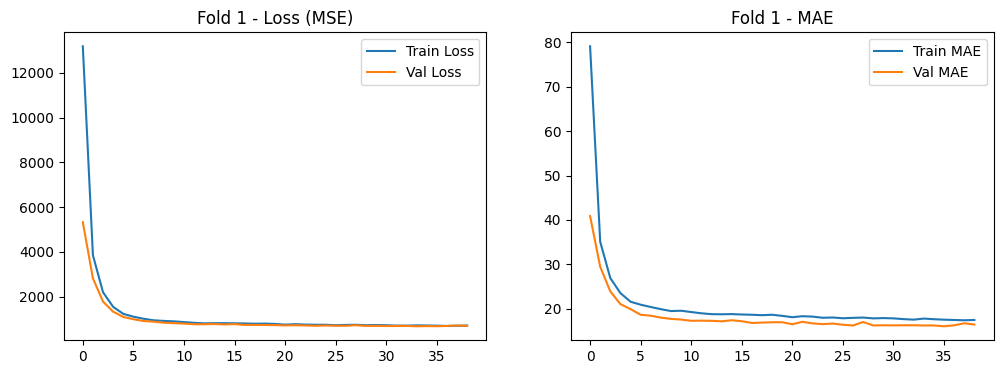

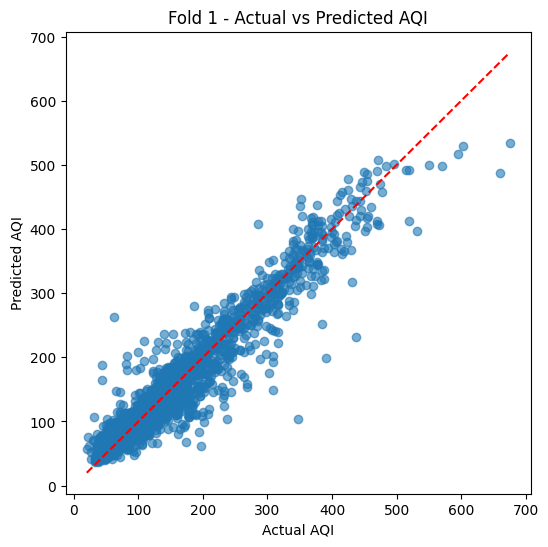

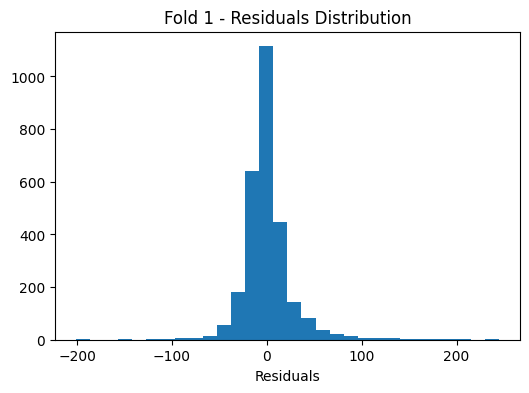

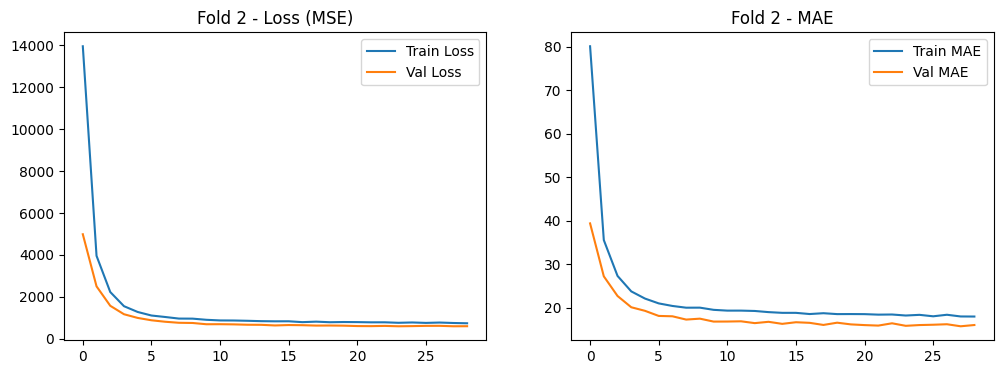

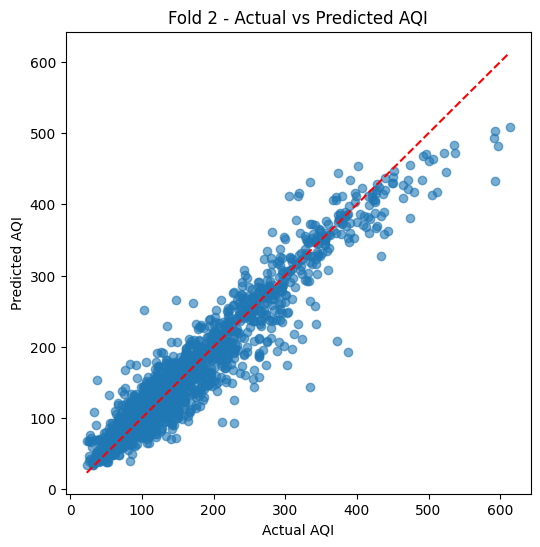

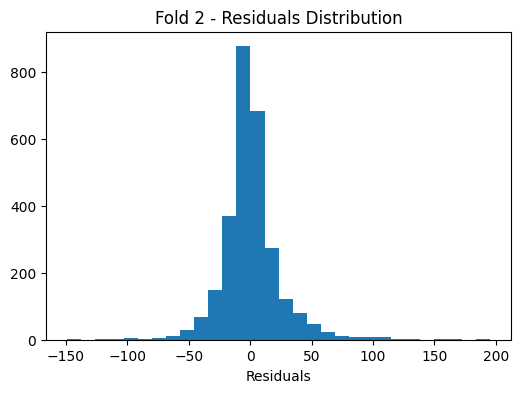

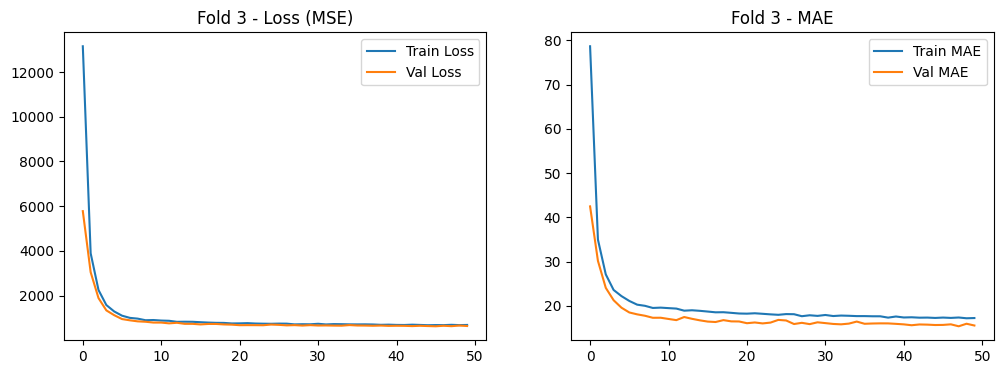

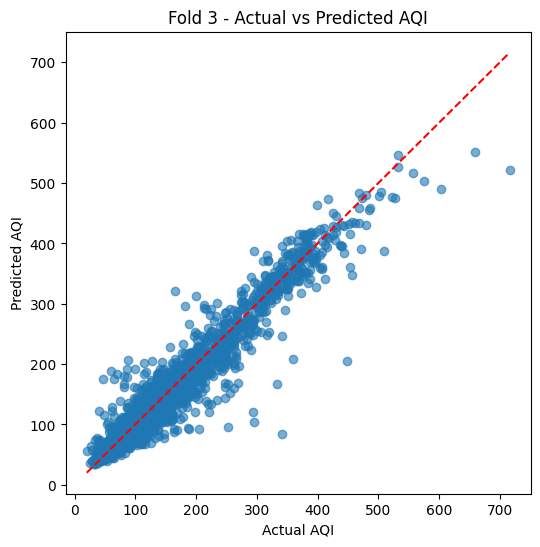

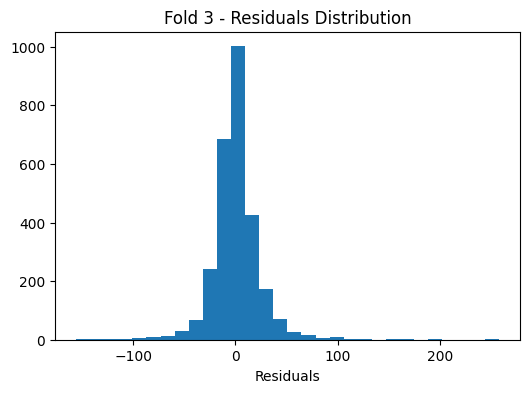

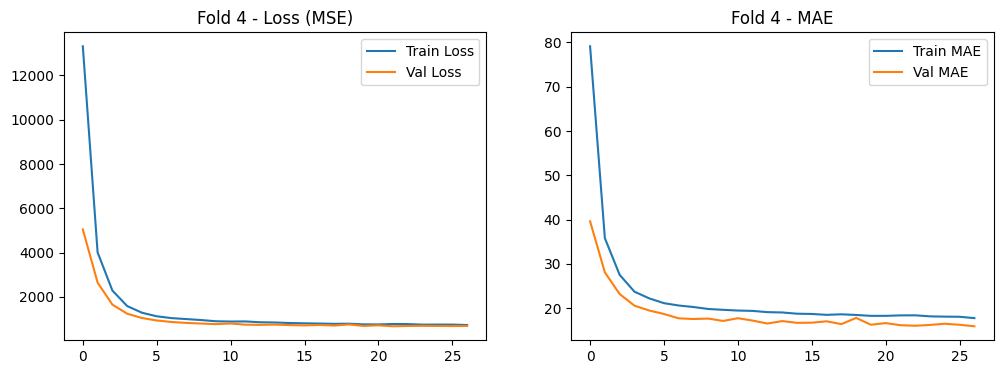

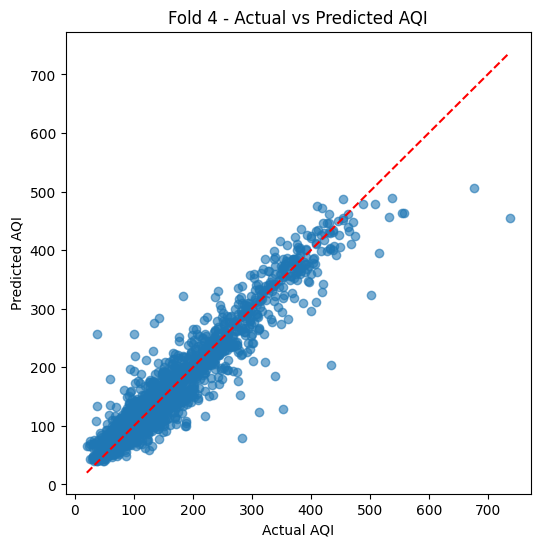

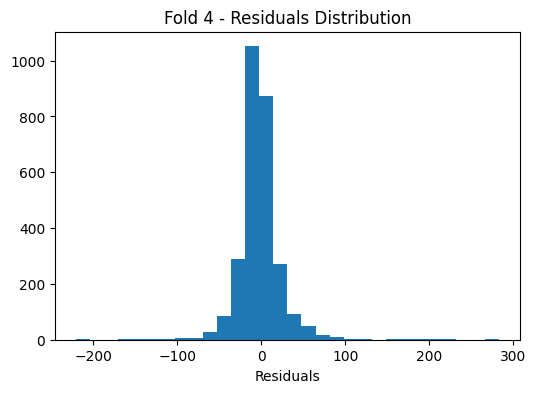

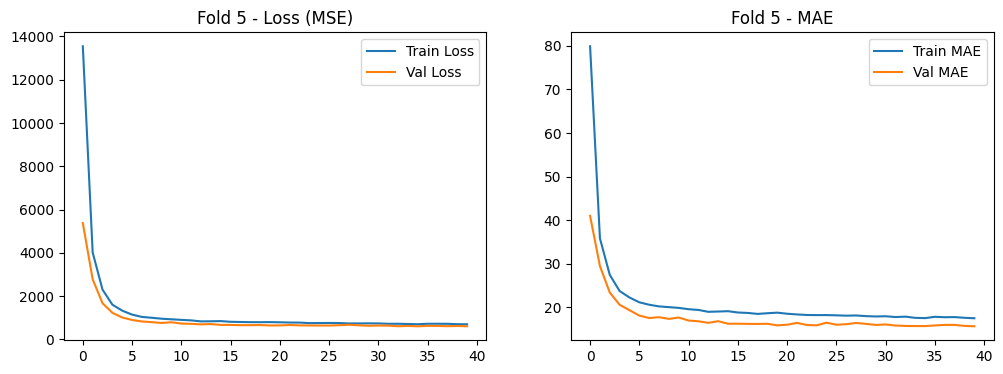

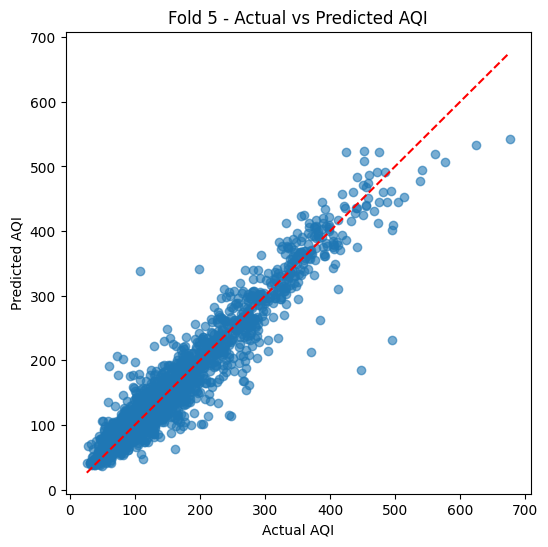

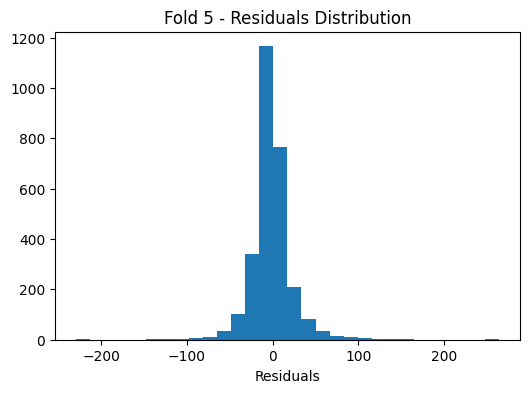

In [ ]:
for i, (history, metrics) in enumerate(zip(histories, fold_metrics)):
    # Loss & MAE
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Fold {i+1} - Loss (MSE)')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title(f'Fold {i+1} - MAE')
    plt.legend()
    plt.show()

    # Predicted vs Actual
    plt.figure(figsize=(6,6))
    plt.scatter(metrics['y_val'], metrics['y_pred'], alpha=0.6)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title(f'Fold {i+1} - Actual vs Predicted AQI')
    plt.plot([metrics['y_val'].min(), metrics['y_val'].max()], [metrics['y_val'].min(), metrics['y_val'].max()], 'r--')
    plt.show()

    # Residuals
    plt.figure(figsize=(6,4))
    plt.hist(metrics['y_val'] - metrics['y_pred'], bins=30)
    plt.xlabel('Residuals')
    plt.title(f'Fold {i+1} - Residuals Distribution')
    plt.show()

In [ ]:
# Aggregate metrics
maes = [m['mae'] for m in fold_metrics]
mses = [m['mse'] for m in fold_metrics]
r2s = [m['r2'] for m in fold_metrics]

print(f'Average MAE: {np.mean(maes):.4f} ± {np.std(maes):.4f}')
print(f'Average MSE: {np.mean(mses):.4f} ± {np.std(mses):.4f}')
print(f'Average R2: {np.mean(r2s):.4f} ± {np.std(r2s):.4f}')

Average MAE: 15.9129 ± 0.2145
Average MSE: 633.9933 ± 31.6290
Average R2: 0.9221 ± 0.0048
